In [ ]:
1-3.3 Flatness v.s. Generalization Part 2


=== Training with batch size = 32 ===
Epoch 01/10 | loss 0.2095 | acc 93.58%
Epoch 02/10 | loss 0.0826 | acc 97.44%
Epoch 03/10 | loss 0.0591 | acc 98.11%
Epoch 04/10 | loss 0.0420 | acc 98.64%
Epoch 05/10 | loss 0.0340 | acc 98.93%
Epoch 06/10 | loss 0.0269 | acc 99.12%
Epoch 07/10 | loss 0.0237 | acc 99.20%
Epoch 08/10 | loss 0.0222 | acc 99.29%
Epoch 09/10 | loss 0.0192 | acc 99.39%
Epoch 10/10 | loss 0.0156 | acc 99.47%
[bsz=32] train_loss=0.0250, test_loss=0.1063, train_acc=99.25%, test_acc=97.75%, sensitivity=0.025082

=== Training with batch size = 64 ===
Epoch 01/10 | loss 0.2388 | acc 92.86%
Epoch 02/10 | loss 0.0875 | acc 97.31%
Epoch 03/10 | loss 0.0576 | acc 98.22%
Epoch 04/10 | loss 0.0425 | acc 98.62%
Epoch 05/10 | loss 0.0337 | acc 98.89%
Epoch 06/10 | loss 0.0240 | acc 99.21%
Epoch 07/10 | loss 0.0227 | acc 99.23%
Epoch 08/10 | loss 0.0194 | acc 99.38%
Epoch 09/10 | loss 0.0167 | acc 99.44%
Epoch 10/10 | loss 0.0146 | acc 99.55%
[bsz=64] train_loss=0.0085, test_loss=0.

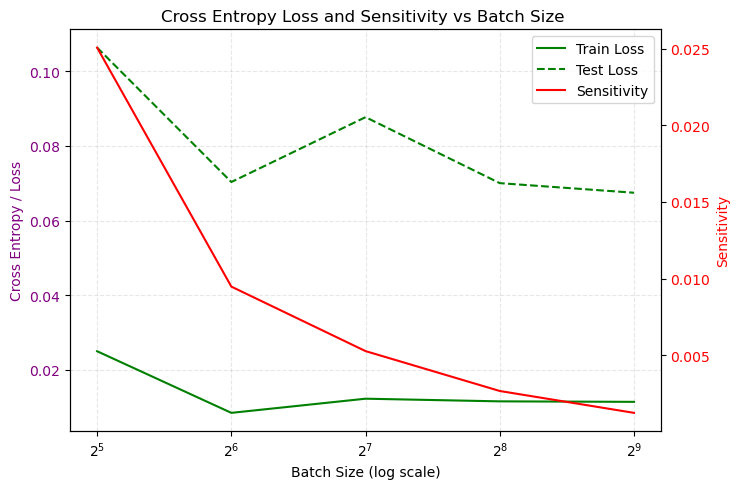

Saved: results/flatness_part2_loss_sens.png, results/flatness_part2_loss_sens.pdf


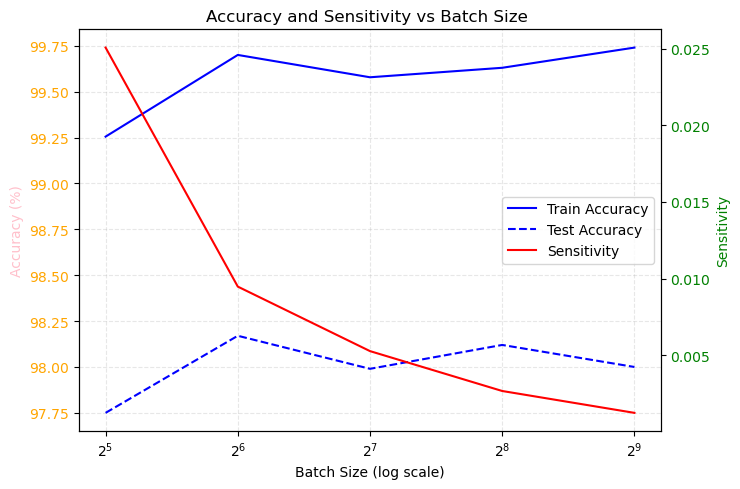

Saved: results/flatness_part2_acc_sens.png, results/flatness_part2_acc_sens.pdf


In [1]:
import os, csv, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision, torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("results", exist_ok=True)
tfm = T.ToTensor()
train_dataset = torchvision.datasets.MNIST(root="./data", train=True,  transform=tfm, download=True)
test_dataset  = torchvision.datasets.MNIST(root="./data", train=False, transform=tfm, download=True)
batch_size_values = [32,64, 128, 256, 512]
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


def train_model(model, optimizer, loader, epochs=10):
    model.to(device).train()
    loss_fn = nn.CrossEntropyLoss()
    for e in range(epochs):
        total_loss, correct, total = 0.0, 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total += y.size(0)
            correct += (logits.argmax(1) == y).sum().item()
        print(f"Epoch {e+1:02d}/{epochs} | loss {total_loss/len(loader):.4f} | acc {100.0*correct/total:.2f}%")
    return evaluate(model, loader)

@torch.no_grad()
def evaluate(model, loader):
    model.eval().to(device)
    loss_fn = nn.CrossEntropyLoss(reduction="sum")
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        total_loss += loss_fn(logits, y).item()
        total += y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
    return total_loss / total, 100.0 * correct / total


def compute_sensitivity(model, loader, sample_limit=5000):
    model.eval().to(device)
    loss_fn = nn.CrossEntropyLoss()
    processed, sens_sum = 0, 0.0
    for x, y in loader:
        if processed >= sample_limit: break
        x, y = x.to(device), y.to(device)
        x.requires_grad_(True)
        logits = model(x)
        loss = loss_fn(logits, y)
        grad_x = torch.autograd.grad(loss, x)[0]
        norms = grad_x.view(grad_x.size(0), -1).norm(dim=1)  # L2 per sample
        sens_sum += norms.sum().item()
        processed += x.size(0)
    return sens_sum / processed if processed > 0 else float("nan")


train_loss_list, test_loss_list = [], []
train_acc_list,  test_acc_list  = [], []
sensitivity_list = []

LR, EPOCHS = 1e-3, 10

for bsz in batch_size_values:
    print(f"\n=== Training with batch size = {bsz} ===")
    train_loader = DataLoader(train_dataset, batch_size=bsz, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_dataset,  batch_size=bsz, shuffle=False, num_workers=2, pin_memory=True)

    model = CustomModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    tr_loss, tr_acc = train_model(model, optimizer, train_loader, epochs=EPOCHS)
    te_loss, te_acc = evaluate(model, test_loader)

    train_loss_list.append(tr_loss)
    test_loss_list.append(te_loss)
    train_acc_list.append(tr_acc)
    test_acc_list.append(te_acc)

    sens = compute_sensitivity(model, test_loader, sample_limit=5000)
    sensitivity_list.append(sens)

    print(f"[bsz={bsz}] train_loss={tr_loss:.4f}, test_loss={te_loss:.4f}, "
          f"train_acc={tr_acc:.2f}%, test_acc={te_acc:.2f}%, sensitivity={sens:.6f}")


csv_path = os.path.join("results", "flatness_part2_metrics.csv")
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["batch_size", "train_loss", "test_loss", "train_acc", "test_acc", "sensitivity"])
    for i, bsz in enumerate(batch_size_values):
        w.writerow([bsz, train_loss_list[i], test_loss_list[i],
                    train_acc_list[i], test_acc_list[i], sensitivity_list[i]])
print(f"Saved metrics CSV: {csv_path}")


def save_and_show(fig, name):
    path_png = os.path.join("results", name + ".png")
    path_pdf = os.path.join("results", name + ".pdf")
    fig.tight_layout()
    fig.savefig(path_png, dpi=150)
    fig.savefig(path_pdf)
    plt.show()
    plt.close(fig)
    print(f"Saved: {path_png}, {path_pdf}")


fig1, ax1 = plt.subplots(figsize=(7.5, 5))
ax1.set_xscale("log", base=2)
ax1.set_xlabel("Batch Size (log scale)")
ax1.set_ylabel("Cross Entropy / Loss", color="purple")
ax1.plot(batch_size_values, train_loss_list, "g-",  label="Train Loss")
ax1.plot(batch_size_values, test_loss_list,  "g--", label="Test Loss")
ax1.tick_params(axis="y", labelcolor="purple")
ax1.grid(alpha=0.3, linestyle="--")

ax2 = ax1.twinx()
ax2.set_ylabel("Sensitivity", color="red")
ax2.plot(batch_size_values, sensitivity_list, "r-", label="Sensitivity")
ax2.tick_params(axis="y", labelcolor="red")

lines, labels = [], []
for ax in [ax1, ax2]:
    L = ax.get_legend_handles_labels()
    lines += L[0]; labels += L[1]
ax1.legend(lines, labels, loc="best")
plt.title("Cross Entropy Loss and Sensitivity vs Batch Size ")
save_and_show(fig1, "flatness_part2_loss_sens")


fig2, ax3 = plt.subplots(figsize=(7.5, 5))
ax3.set_xscale("log", base=2)
ax3.set_xlabel("Batch Size (log scale)")
ax3.set_ylabel("Accuracy (%)", color="blue")
ax3.plot(batch_size_values, train_acc_list, "b-",  label="Train Accuracy")
ax3.plot(batch_size_values, test_acc_list,  "b--", label="Test Accuracy")
ax3.tick_params(axis="y", labelcolor="blue")
ax3.grid(alpha=0.3, linestyle="--")

ax4 = ax3.twinx()
ax4.set_ylabel("Sensitivity", color="red")
ax4.plot(batch_size_values, sensitivity_list, "r-", label="Sensitivity")
ax4.tick_params(axis="y", labelcolor="red")

lines, labels = [], []
for ax in [ax3, ax4]:
    L = ax.get_legend_handles_labels()
    lines += L[0]; labels += L[1]
ax3.legend(lines, labels, loc="best")
plt.title("Accuracy and Sensitivity vs Batch Size ")
save_and_show(fig2, "flatness_part2_acc_sens")
